## Creating dataset

In [1]:
import os
os.chdir('../mimic')
from process_mimic import create_merged, get_first_data
import pandas as pd
from scipy import stats
import errno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Run process_mimic functions to get daily and admission data.

In [2]:
try:
    os.makedirs('data_processed')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In [3]:
%%time
df = create_merged()
df_first = get_first_data(df)

[    INFO |     process_mimic.py:337]   Starting preprocessing of MIMIC data
[   DEBUG |     process_mimic.py: 64]   Reading already processed chartevents file data_processed/mimic_chartevents.csv
[   DEBUG |     process_mimic.py: 67]   Read already processed chartevents file data_processed/mimic_chartevents.csv. 28190659 rows.
[   DEBUG |     process_mimic.py:115]   Creating day blocks
[   DEBUG |     process_mimic.py:124]   Created day blocks. 218696 rows, 38385 unique admissions
[   DEBUG |     process_mimic.py:140]   Adding derived columns
[   DEBUG |        operations.py:  6]   Adding BMI
[    INFO |             utils.py:129]   Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[    INFO |             utils.py:141]   NumExpr defaulting to 8 threads.
[   DEBUG |        operations.py: 13]   Adding PaO2/FiO2
[    INFO |     process_mimic.py:261]   Getting admission data
[    INFO |     process_mimic.py:190]   Getting procedures
[    INFO 

Wall time: 54.6 s


## Extra feature processing

In [4]:
# make these columns (normally in first day only) present accross all days
df = df.drop(['Weight_kg', 'Height_inches', 'BMI'], axis=1).merge(
    df_first[['Weight_kg', 'Height_inches', 'BMI']], on='HADM_ID')

In [5]:
# convert gender to 0 or 1
df['GENDER'] = (df['GENDER'] == 'M').astype(int)

In [6]:
# get rid of inf values
df = df.replace([np.inf, -np.inf], np.nan)

In [7]:
# get all numeric columns
all_numeric_cols = [x for x in df.columns if df[x].dtypes == np.float64 or df[x].dtypes == np.int64]

In [8]:
# destroy all negative values
df = df[~(df[all_numeric_cols] < 0).any(axis=1)]

## Feature count

In [9]:
df.count().sort_values(ascending=False)

index                             218007
Obesity                           218007
SUBJECT_ID                        218007
ADMITTIME                         218007
DAYS_TO_DISCH                     218007
DEATH                             218007
GENDER                            218007
AGE                               218007
Asthma                            218007
Chronic Kidney Disease            218007
Heart disease                     218007
CHARTDATE                         218007
HADM_ID                           218007
Day                               218007
DIAGNOSIS                         218006
HR                                204712
RR                                204026
SaO2                              199394
Weight_kg                         195829
Potassium                         148062
Creatinine                        147914
Sodium                            146853
Height_inches                     144263
BMI                               126515
FiO2            

In [10]:
df_first.count().sort_values(ascending=False)

Day                               38385
Asthma                            38385
CHARTDATE                         38385
SUBJECT_ID                        38385
ADMITTIME                         38385
DAYS_TO_DISCH                     38385
DEATH                             38385
GENDER                            38385
AGE                               38385
index                             38385
Chronic Kidney Disease            38385
Heart disease                     38385
Obesity                           38385
DIAGNOSIS                         38384
HR                                35951
RR                                35924
SaO2                              35387
Weight_kg                         31826
Creatinine                        31633
Potassium                         31629
Sodium                            31618
HCO3                              24061
Platelet_count                    23984
Haemoglobin                       23983
bp_systolic                       21685


## Data summary

In [11]:
df.describe()

,index,HADM_ID,ALT,AST,Bilirubin,CRP,CVP,Creatinine,Diastolic_BP,FiO2,HCO3,HR,Haemoglobin,Mean Arterial Pressure,PCO2,PEEP_set,PaCO2,PaO2,Plateau_Pressure,Platelet_count,Potassium,RR,SaO2,Sodium,Tidal,Tidal_ml,Total_PEEP,Total_PEEP_cmH2O,apache2,arterial_bp_diastolic,arterial_bp_systolic,bp_diastolic,bp_systolic,mean_airway_pressure,pH,sofa,temperature_c,PaO2/FiO2,SUBJECT_ID,DAYS_TO_DISCH,DAYS_TO_DEATH,DEATH,GENDER,AGE,Asthma,Chronic Kidney Disease,Heart disease,Obesity,intubation_DAYSTO,intubation_VALUE,invasive_ventilation_DAYSTO,invasive_ventilation_VALUE,noninvasive_ventilation_DAYSTO,noninvasive_ventilation_VALUE,Day,Weight_kg,Height_inches,BMI
count,218007.000000,218007.000000,47197.000000,199.000000,6.000000,713.000000,53625.000000,147914.000000,4489.000000,108831.000000,105910.000000,204712.000000,104307.000000,81863.000000,2587.000000,76044.000000,47501.000000,82315.000000,46154.000000,104529.000000,148062.000000,204026.000000,199394.000000,146853.000000,2.000000,43582.000000,717.000000,18040.000000,15.000000,43842.000000,43845.000000,82325.000000,82375.000000,75407.000000,50433.000000,2.000000,69065.000000,65573.000000,218007.000000,218007.000000,29338.000000,218007.000000,218007.000000,218007.000000,218007.000000,218007.000000,218007.000000,218007.000000,33914.000000,33914.0,64034.000000,64034.000000,9534.000000,9534.000000,218007.000000,195829.000000,144263.000000,126515.000000
mean,109337.818891,149983.000647,168.189044,123.417085,5.816667,100.627630,15.808371,1.492604,60.294275,33.579220,25.349076,98.929196,10.110257,81.643148,49.272219,6.574616,42.315067,129.336078,20.869201,233.768564,4.080977,25.094429,96.967627,139.094159,405.000000,504.876342,11.505523,7.998282,25.866667,65.856256,121.072391,64.699532,120.193287,10.533706,7.409285,10.000000,37.040188,122.873510,34525.226548,23.947777,22.754994,0.134574,0.569720,53.206535,0.058594,0.090717,0.001440,0.056957,6.249661,1.0,2.961255,9456.924197,7.788232,1537.193413,11.032751,67.548262,54.252144,32.055924
std,63133.397182,28897.441302,612.187128,354.344325,8.997426,82.905403,35.789571,2.510540,65.678476,31.053773,5.115747,192.665255,1.800007,22.056119,13.305738,3.174734,11.138773,72.402727,6.140964,141.473583,0.976413,13.736465,4.252816,4.931158,35.355339,4295.875363,5.412701,18.946142,11.050964,725.294615,24.317375,262.372006,23.108845,4.399834,3.256316,1.414214,3.063383,164.744581,32131.590427,28.110350,24.940487,0.341268,0.495116,28.429208,0.234865,0.287207,0.037924,0.231761,10.497170,0.0,6.941326,13839.712711,11.446093,2595.602773,17.842139,39.041546,22.472252,348.948207
min,0.000000,100001.000000,0.000000,14.000000,0.400000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,380.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,2.000000,0.000000,0.360000,0.000000,0.597733
25%,54656.500000,125055.000000,19.000000,28.000000,0.850000,26.800000,7.000000,0.700000,50.000000,0.500000,22.000000,76.000000,8.800000,69.000000,41.000000,5.000000,35.000000,86.000000,17.000000,139.000000,3.700000,16.000000,96.000000,136.000000,392.500000,407.000000,7.700000,5.000000,19.500000,51.000000,104.000000,52.000000,104.000000,8.000000,7.350000,9.500000,36.444401,2.280000,6606.000000,7.000000,7.000000,0.000000,0.000000,41.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,1199.000000,1.000000,171.000000,1.000000,54.400000,56.000000,11.942917
50%,109341.000000,149807.000000,37.000000,47.000000,1.800000,80.000000,11.000000,1.000000,58.000000,40.000000,25.000000,90.000000,9.900000,79.000000,48.000000,5.000000,41.000000,109.000000,20.000000,207.000000,4.000000,21.000000,98.000000,139.000000,405.000000,485.000000,11.000000,6.000000,24.000000,59.000000,118.

In [12]:
def plot_feature(col, df, remove_outliers=False):
    '''Plot a feature. Note, this code removes outliers and doesn't plot binary plots.
    
    '''
    if col == 'index' or col == 'HADM_ID':
        return
    
    if df[df.DEATH==0][col].dtypes != np.float64 and df[df.DEATH==0][col].dtypes != np.int64:
        return
    
    minimum = df[col].dropna().min()
    maximum = df[col].dropna().max()
    
    if minimum == 0 and maximum == 1:
        return

    # remove outliers 
    if remove_outliers:
        df = df[np.abs(df[col]-df[col].mean()) <= (3 * df[col].std())]
    
    died = df[df.DEATH==1][col].dropna()
    discharged = df[df.DEATH==0][col].dropna()
    
    minimum = df[col].dropna().min()
    maximum = df[col].dropna().max()
    
    bins = np.linspace(minimum, maximum, num=23)
            
    sns.distplot(discharged, kde=False, bins=bins, label="Discharged")
    fig = sns.distplot(died, kde=False, bins=bins, label="Died")
    plt.title(f'Histogram for {col.title()}')
    plt.ylabel('Count')
    plt.xlabel(str(col.title()))
    plt.legend()
    plt.show(fig)

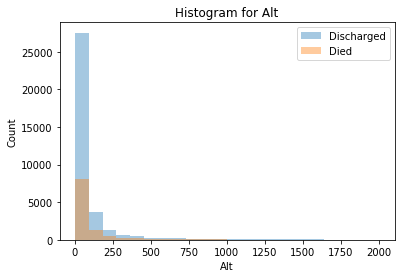

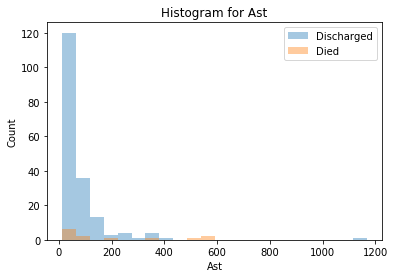

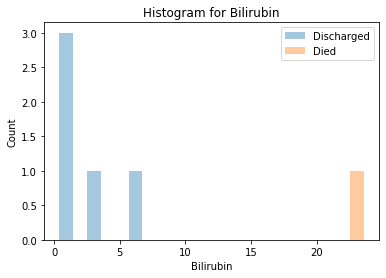

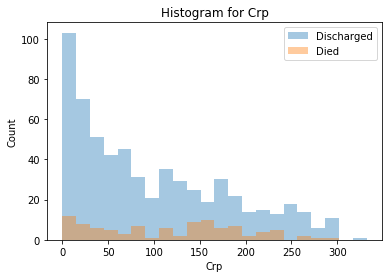

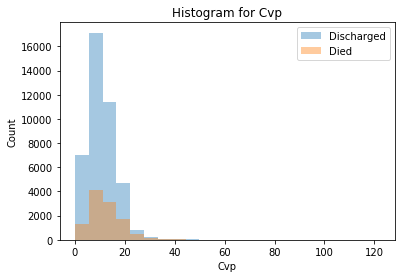

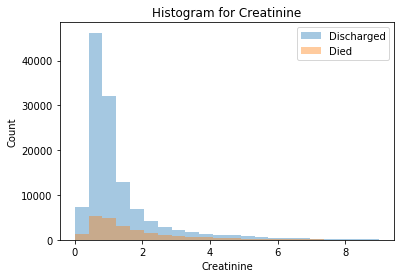

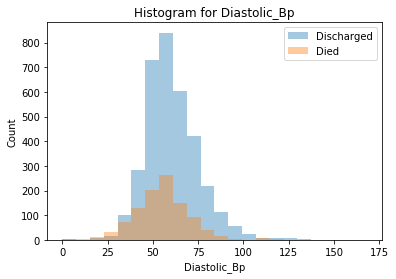

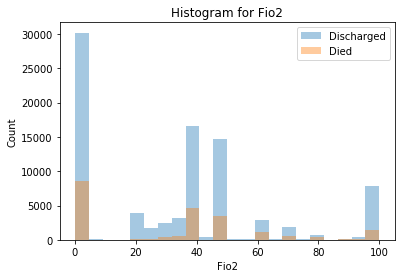

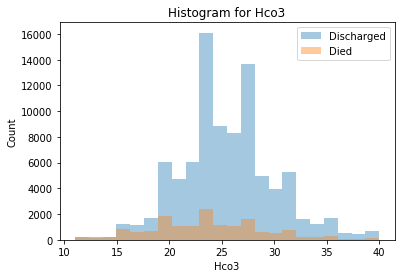

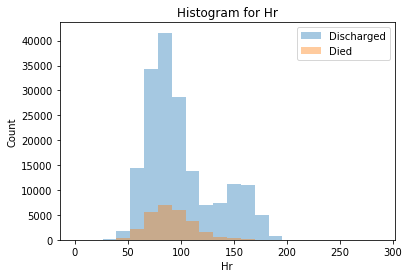

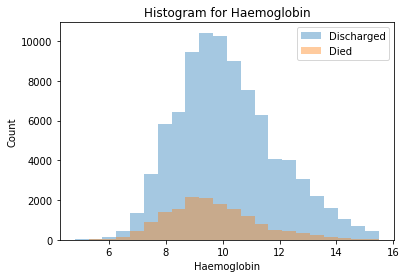

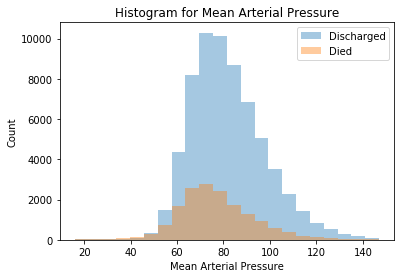

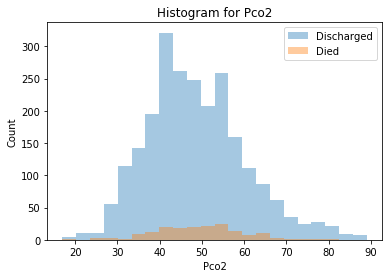

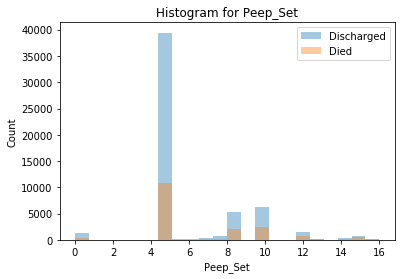

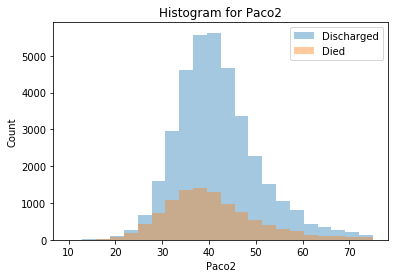

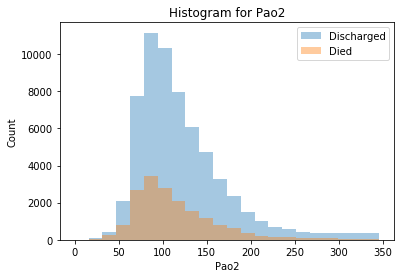

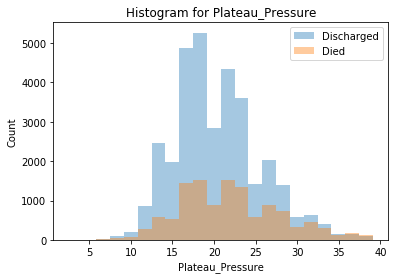

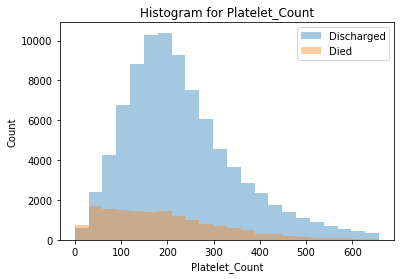

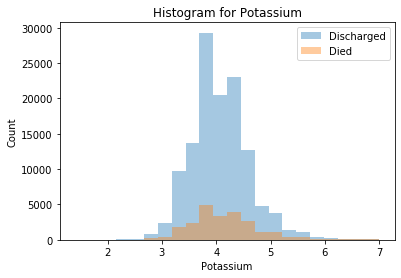

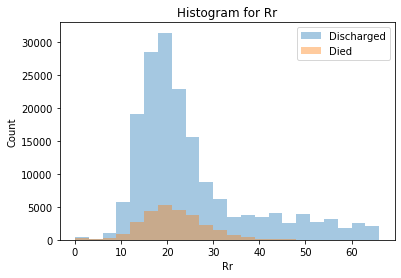

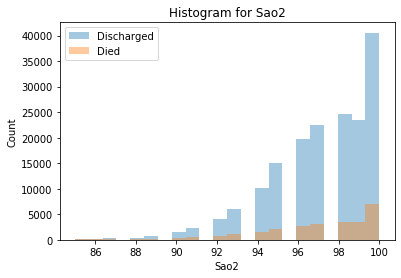

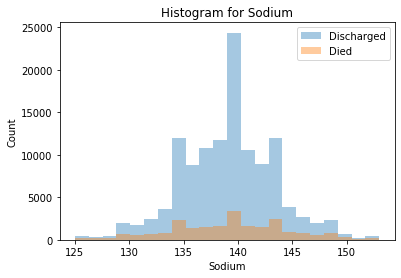

C:\Users\2gare\Anaconda3\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\2gare\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


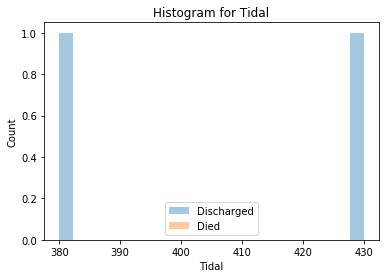

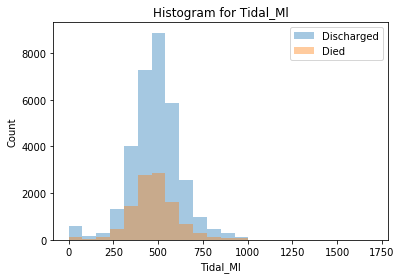

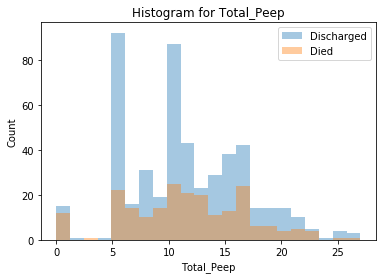

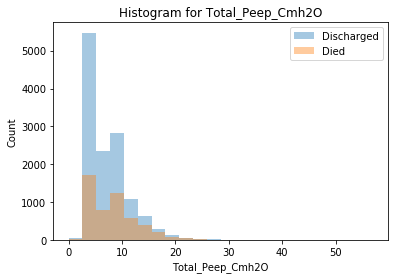

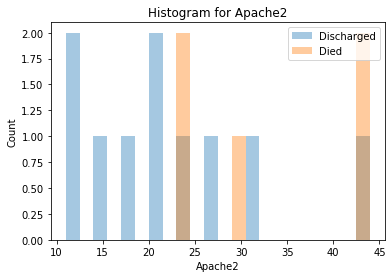

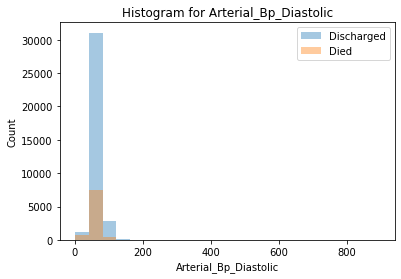

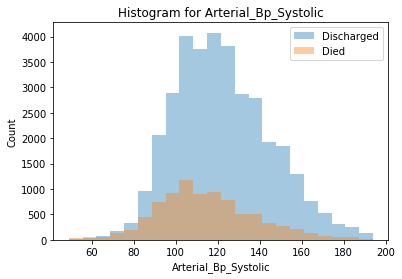

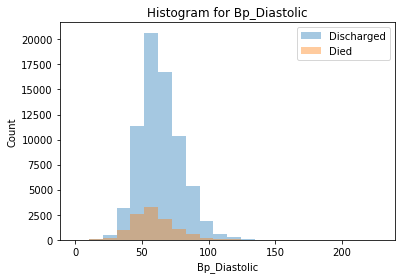

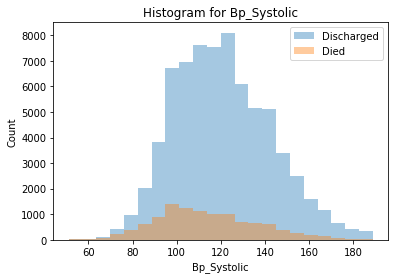

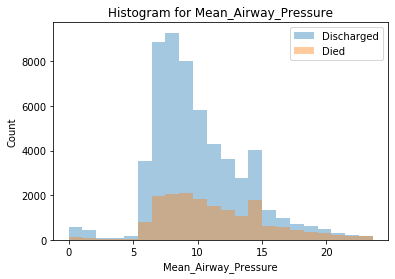

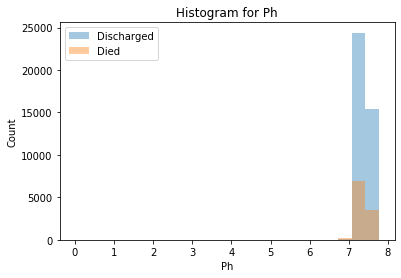

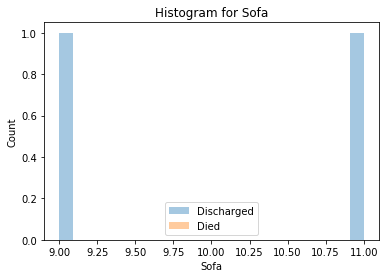

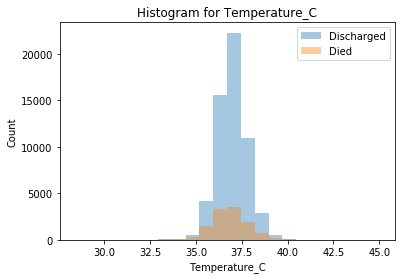

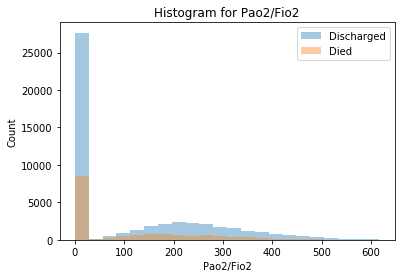

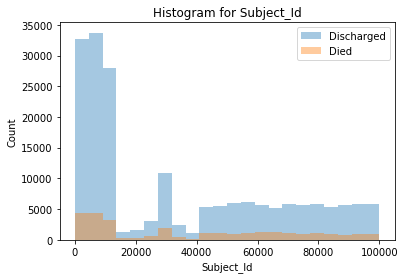

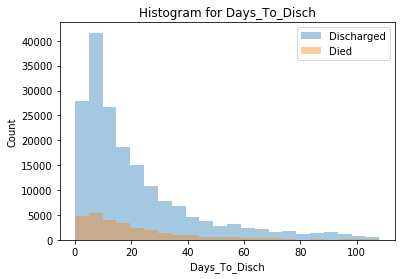

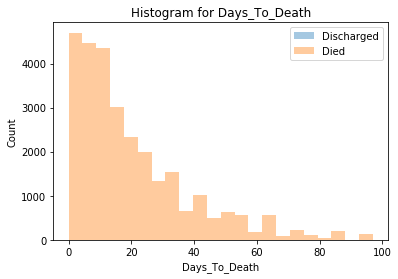

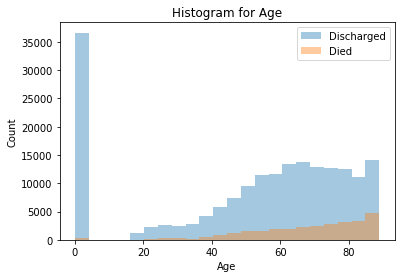

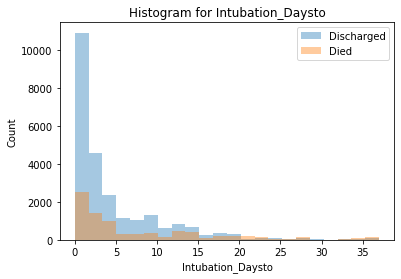

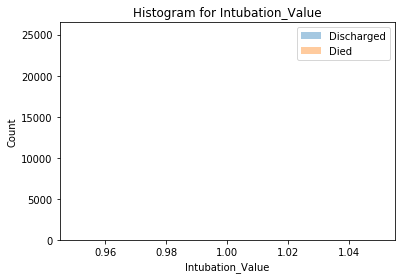

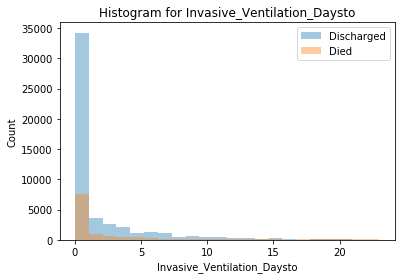

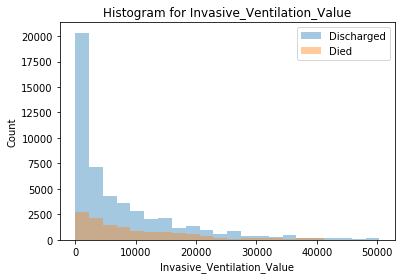

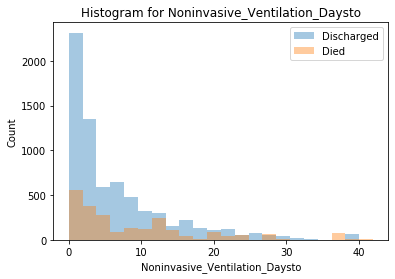

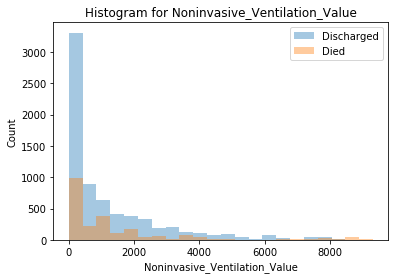

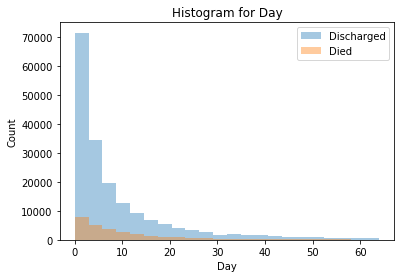

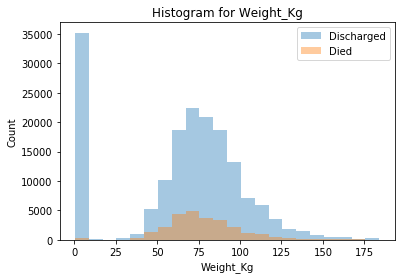

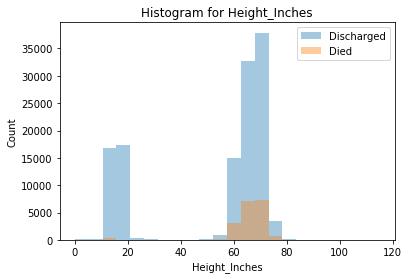

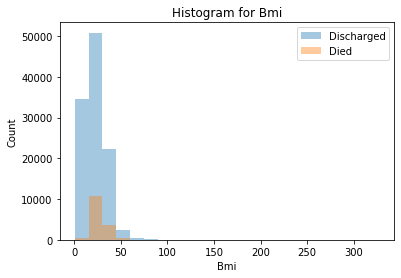

In [13]:
for col in df.columns:
    plot_feature(col, df, remove_outliers=True)

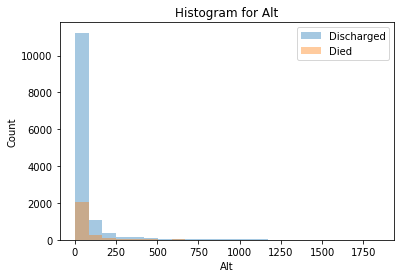

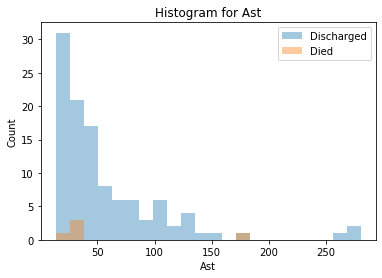

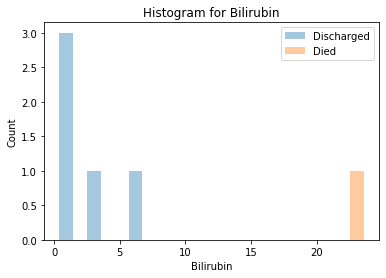

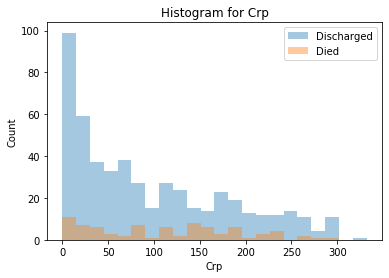

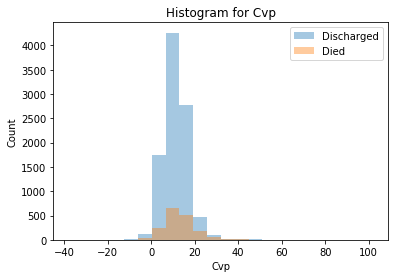

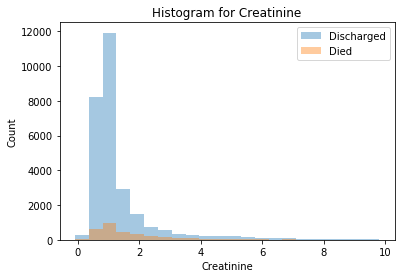

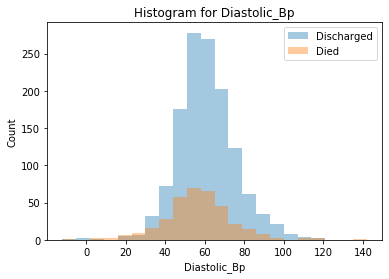

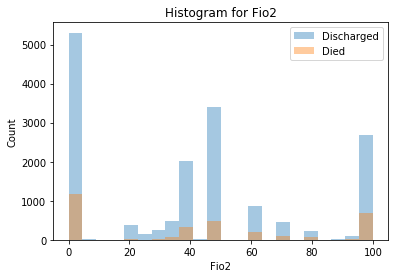

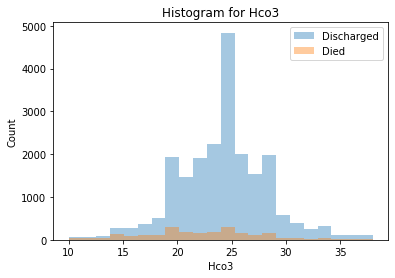

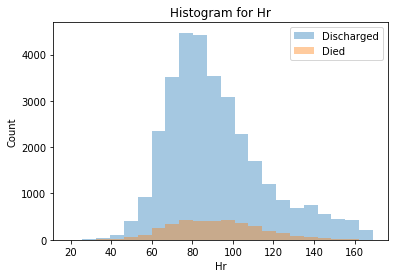

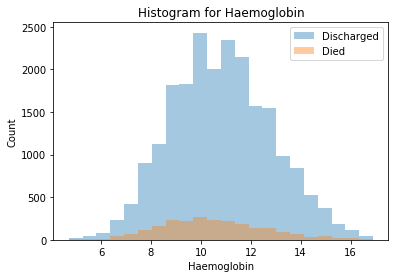

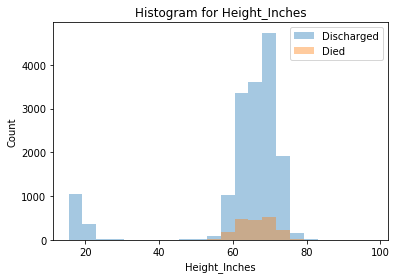

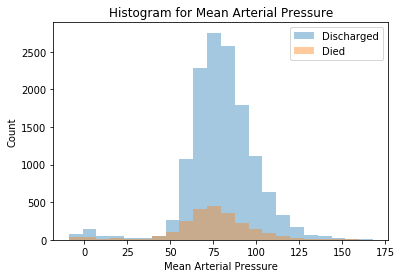

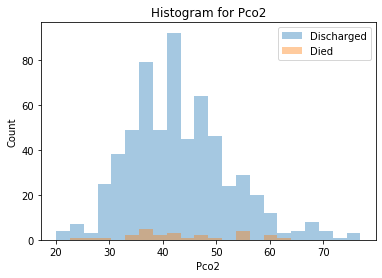

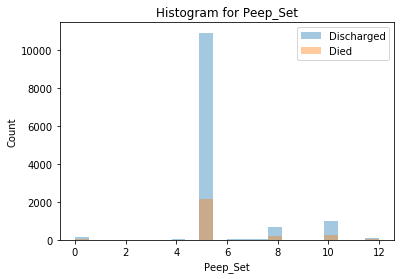

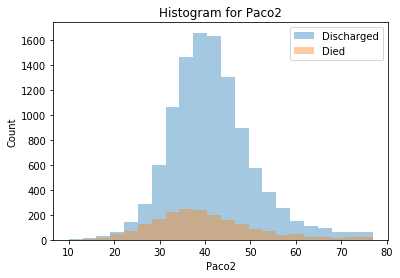

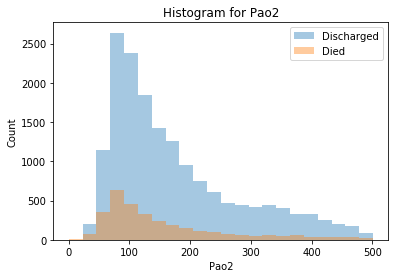

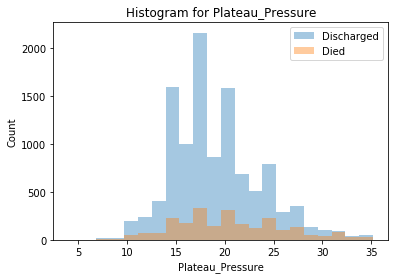

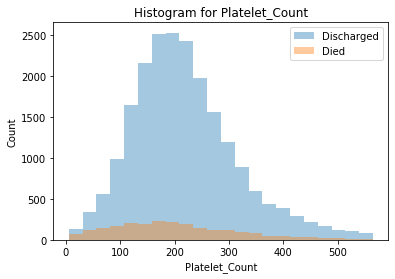

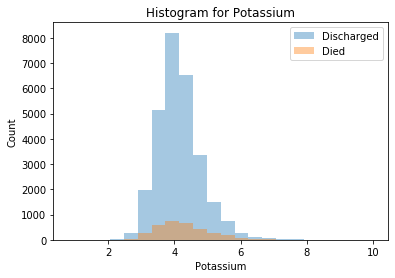

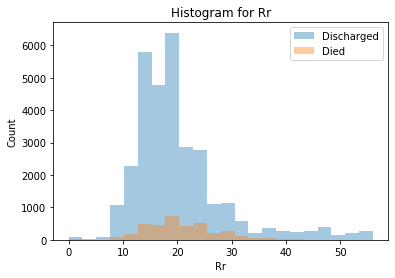

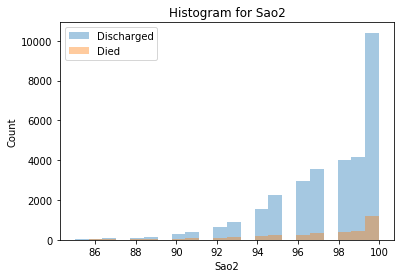

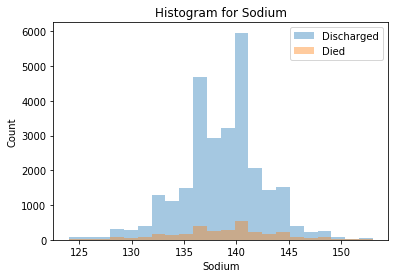

C:\Users\2gare\Anaconda3\lib\site-packages\numpy\lib\histograms.py:421: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):


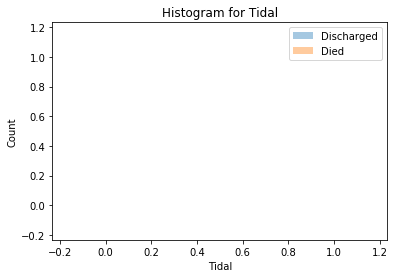

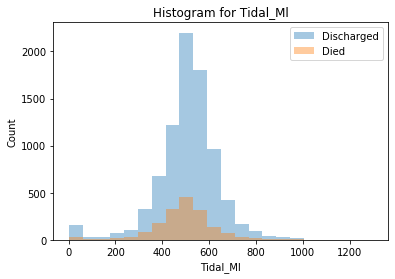

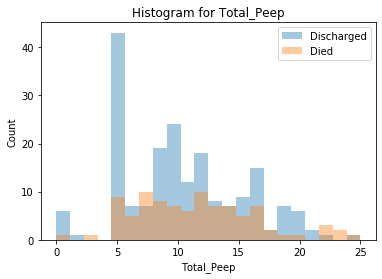

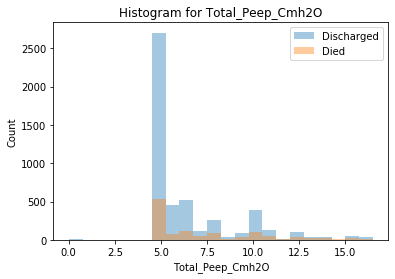

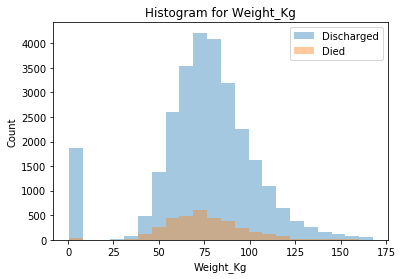

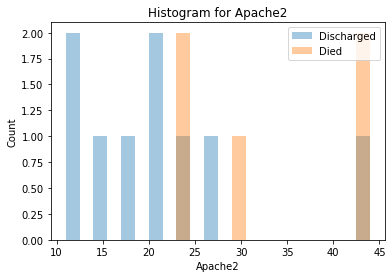

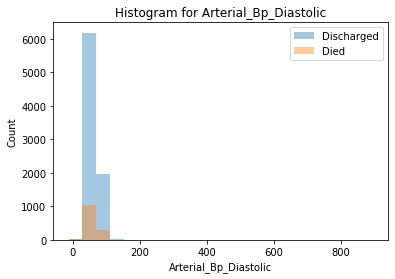

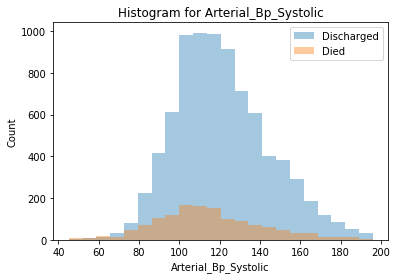

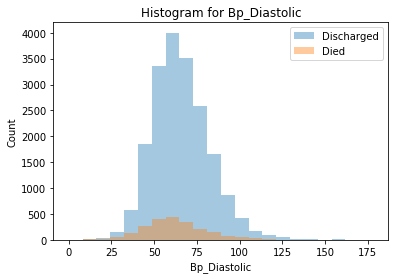

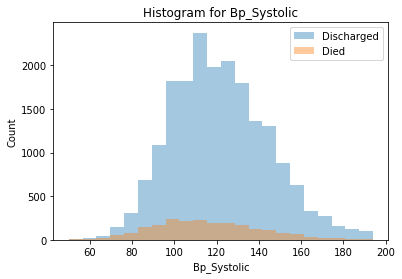

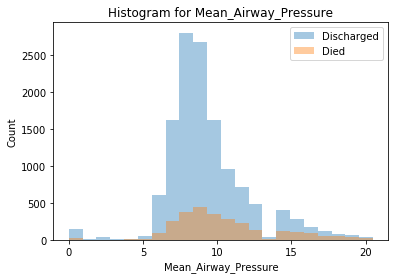

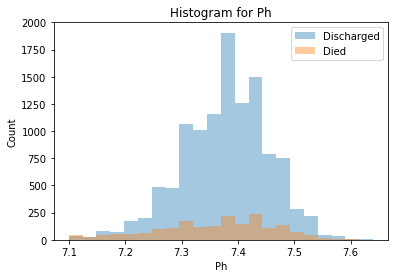

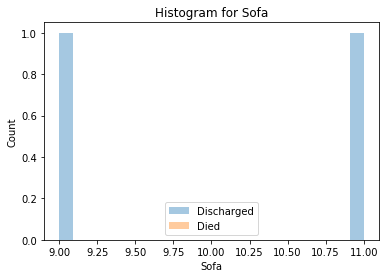

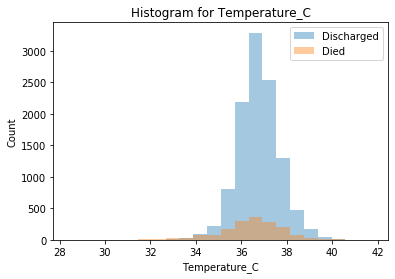

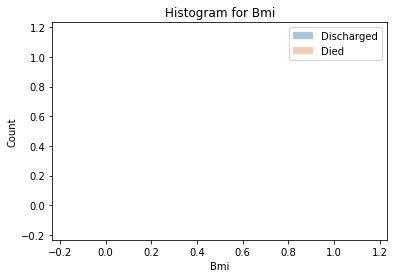

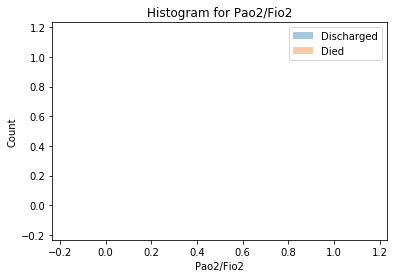

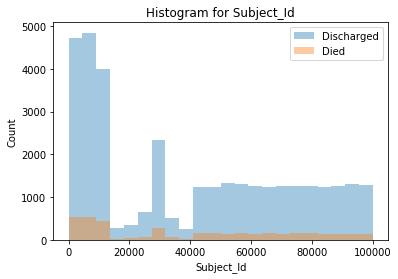

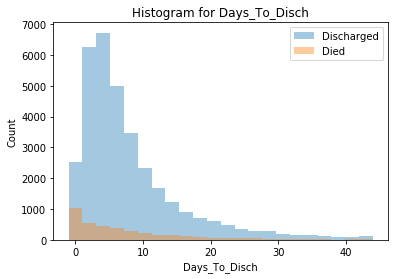

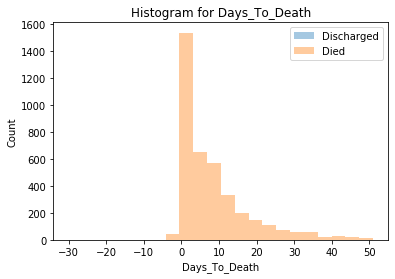

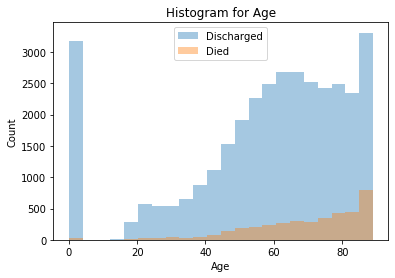

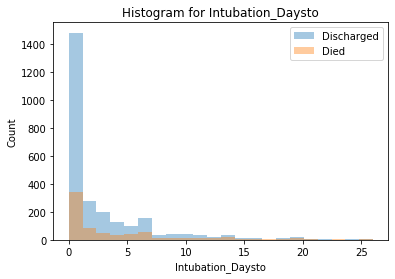

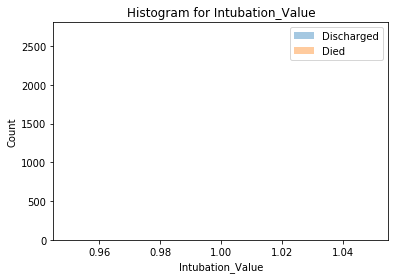

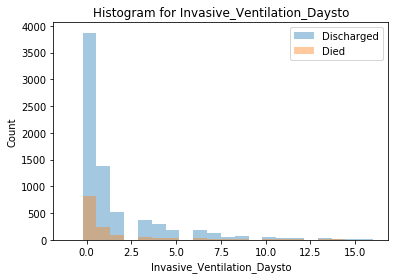

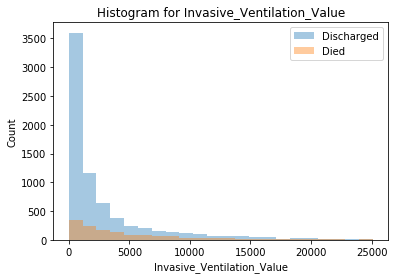

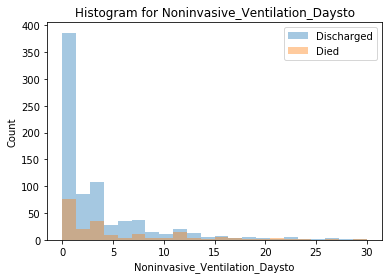

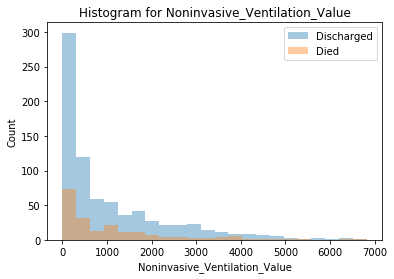

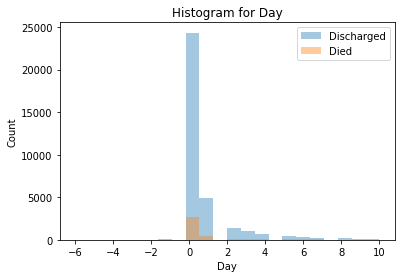

In [14]:
for col in df_first.columns:
    plot_feature(col, df_first, remove_outliers=True)

### Death

In [15]:
df['DEATH'].value_counts()

0    188669
1     29338
Name: DEATH, dtype: int64

In [16]:
df_first['DEATH'].value_counts()

0    34428
1     3957
Name: DEATH, dtype: int64

### Choose features
Must choose a subset of features, as some of these have almost no data.
Choose features with most rows

TODO add ventilatory related features

In [17]:
numeric = [
    'Creatinine', 'HCO3', 'HR', 'Haemoglobin',
    'Platelet_count', 'Potassium', 'RR',
    'Sodium', 'Weight_kg', 'SaO2',
]

my_cols = numeric + [
    'HADM_ID', 'CHARTDATE', 
    'DAYS_TO_DISCH', 'AGE', 'GENDER', 'Day', 'DEATH',
    "Chronic Kidney Disease", "Obesity", "Heart disease", "Asthma", # comorbidities
]

In [18]:
features = df[my_cols]
features.count()

Creatinine                147914
HCO3                      105910
HR                        204712
Haemoglobin               104307
Platelet_count            104529
Potassium                 148062
RR                        204026
Sodium                    146853
Weight_kg                 195829
SaO2                      199394
HADM_ID                   218007
CHARTDATE                 218007
DAYS_TO_DISCH             218007
AGE                       218007
GENDER                    218007
Day                       218007
DEATH                     218007
Chronic Kidney Disease    218007
Obesity                   218007
Heart disease             218007
Asthma                    218007
dtype: int64

In [19]:
features = features.dropna()
features.count()

Creatinine                89875
HCO3                      89875
HR                        89875
Haemoglobin               89875
Platelet_count            89875
Potassium                 89875
RR                        89875
Sodium                    89875
Weight_kg                 89875
SaO2                      89875
HADM_ID                   89875
CHARTDATE                 89875
DAYS_TO_DISCH             89875
AGE                       89875
GENDER                    89875
Day                       89875
DEATH                     89875
Chronic Kidney Disease    89875
Obesity                   89875
Heart disease             89875
Asthma                    89875
dtype: int64

In [20]:
# number of patients data we still have
features['HADM_ID'].unique().shape

(21443,)

In [36]:
drop_hadm = []

for hadm in features['HADM_ID'].unique():
    # use the below instead to make the data selection more strict
#     if len(data[data.HADM_ID == hadm]) - 1 == max(data[data.HADM_ID == hadm]['Day']) \
#             == max(data[data.HADM_ID == hadm]['DAYS_TO_DISCH']):
    if max(features[features.HADM_ID == hadm]['Day']) == max(features[features.HADM_ID == hadm]['DAYS_TO_DISCH']):# and \
#             min(features[features.HADM_ID == hadm]['Day']) == 0:
        continue
    drop_hadm.append(hadm)

In [37]:
complete_data = features[~features.HADM_ID.isin(drop_hadm)]

In [38]:
complete_data['HADM_ID'].unique().shape

(2935,)

In [39]:
complete_data.columns

Index(['Creatinine', 'HCO3', 'HR', 'Haemoglobin', 'Platelet_count', 'Potassium', 'RR', 'Sodium', 'Weight_kg', 'SaO2', 'HADM_ID', 'CHARTDATE', 'DAYS_TO_DISCH', 'AGE', 'GENDER', 'Day', 'DEATH', 'Chronic Kidney Disease', 'Obesity', 'Heart disease', 'Asthma'], dtype='object')

## Remove outliers

delete outliers (e.g. 0 RR, 0 HR, very high heart rate)

calculate zscore of every point, remove rows with any zscores > 4

Note that this number is chosen to ensure RR=0 is not removed. This removes too many patients who died.

In [40]:
zscore = abs(complete_data[numeric] - complete_data[numeric].mean()) / complete_data[numeric].std()
no_outliers = complete_data[(zscore < 4).all(axis=1)]

In [41]:
no_outliers['HADM_ID'].value_counts().count()

2870

In [44]:
no_outliers.shape

(15097, 21)

In [42]:
no_outliers.to_csv('data_processed/mimic_dataset_incomplete.csv', index=False)